In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats

%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore")

#### Gather & Clean functions 

In [2]:
 def col_name(a):
            
        """ function to find the colname in a data set that contains the Prog. Languages, since the col names
        are different from one data set to another"""
        
        # creating list of columns name
        mylist = [i for i in list(a)]
        
        #Prog. Lang. column name differ from a year to another
        pattern =[".*WorkedLanguage", "tech_do", "LanguageWorked*."] 
    
        for pat in pattern:
            #for each patter check if there is a match in the col. list and add to a list
            r = re.compile(pat)  
            newlist = list(filter(r.match, mylist)) 
        
            if len(newlist) >0:       # if the len of the new list is >0(contains an element)->break the loop
                                      #we have found the col. 
                    col = newlist[0]
                    break
                    
        return col 

In [3]:
def Prog_Lang_list(a):
        
    """ function to create a list of the unique programming names in the data set and 
    re-arrange it, extract unique values according to current format in Prog. Lang. values in rows"""
    
    #creating a list of unique programming languges from the colum
    languages = list(a.unique())
        
    #remove nan from list of languages
    languages = [x for x in languages if str(x) != 'nan']
        
    #spliting the strings in each row of programing languages separated with ';' e.g. 'C#;HTML/CSS;JavaScript'
    Prog_Lang = []
    for i in range(0, len(languages)-1):
        element = languages[i].split(';')
        Prog_Lang += element
        
    # lower the strings and remove white spaces 
    Prog_Lang = [x.lower().replace(" ", "") for x in Prog_Lang]
        
    # removing redundant programing languges from the list 
    Prog_Lang= set(Prog_Lang)
    Prog_Lang= list(Prog_Lang)
    return Prog_Lang

In [4]:
def read_csv2015(a):
    
    """ function to read the csv file of 2015 and extract Prog. Lang. names and
    create a data frame of prog. lang. and their counts"""
    
    file= 'survey_results'+a+'.csv'
    df= pd.read_csv(file, header=1)
            
    #extracting the current tech and langu. columns 
    mylist = [i for i in list(df.columns)]
    r = re.compile("Current*.")
    newlist = list(filter(r.match, mylist))
            
    #slicing the dataframe according the the columns 
    df= df[newlist]
            
    #filling NaN with zeros 
    df = df.fillna(0)
            
    #converting the columns to one and zeros 
            
    df = df.astype(bool).astype(int)
            
    #changing columns names/extracting the tech/lang, name
            
    df.columns = [i.split(':')[1].strip() for i in df.columns]
            
            
    #creating a df and counting the lang/tech in rows 
    PrLang = list(df.sum(axis=0).sort_values().reset_index()['index'])
        
    count = list(df.sum(axis=0).sort_values().reset_index()[0])
        
    dfLang= pd.DataFrame({'PrLang':PrLang, 'count':count})
    
    return dfLang

In [5]:
 def read_csv(a):
        
    """ function to read the csv file of any year from 2016 to 2020 and extract Prog. Lang. names and
    create a data frame of prog. lang. and their counts"""
    
    file= 'survey_results'+a+'.csv'
        
    df= pd.read_csv(file)
        
    #extracting the column name of programming languages with predefined function
    """ predefined function"""
    colName = col_name(df.columns)
        
        
    #creating a list of unique programming languges from the colum with predefined function
    """ predefined function"""
    ProgLangList = Prog_Lang_list(df[colName])
        
    #subsetting the main dataframe with only the programing lang. column according to its predefined name in the data set
    # previously exctracted 
        
    df_subset= df[[colName]]
    df_subset.dropna(inplace=True)
        
    # creating columns from the separated programing languges names, and filling the columns with 0': dummy variables
        
    df_subset[ProgLangList] = 0
        
    # removing c++ from the languages list, it created with the subqequent for loop some issue
    # due to the implementation of Regex
        
    if 'c++' in ProgLangList:
        ProgLangList.remove('c++')
        
        # filling each single programing language col. with 1 where the language is present in the string, in the row 
        for lang in ProgLangList:
            df_subset.loc[df_subset[colName].str.lower().str.contains(';{0};|;{0}$|^{0};|^{0}$'.format(lang), regex=True), lang] = 1
        
        # filling the c++ column, where c++ is present in each row, where languges strings contains c++
            
        df_subset.loc[df_subset[colName].str.lower().str.contains(';c\+\+;|;c\+\+$|^c\+\+;|^c\+\+$', regex=True), 'c++'] = 1
         
        
    else:
            
        for lang in ProgLangList:
            df_subset.loc[df_subset[colName].str.lower().str.contains(';{0};|;{0}$|^{0};|^{0}$'.format(lang), regex=True), lang] = 1
        
        
        
    #subsetting the dataframe with dummy variables only 
    df_subset = df_subset.iloc[0: , 1:]
        
    # summing the dummy variables and creating a dataframe of languages count in the survey and sorting in Asc.
        
    PrLang = list(df_subset.sum(axis=0).sort_values().reset_index()['index'])
        
    count = list(df_subset.sum(axis=0).sort_values().reset_index()[0])
        
    dfLang= pd.DataFrame({'PrLang':PrLang, 'count':count})
    
    return dfLang
        

#### Visualize function

In [6]:
def Visualize():

    """ Function to read csv file with embedded functions
    and visualize braplots of programming languges in order"""

    
    # first conditionned input to chose to read all csv or a particular year of survey results
    # raising an Error as per the set and allowed inputs with try-except block
    
    condition= True 
    
    while condition:
        
        try:
            answer= input('Would you like the surveys data and visualize barplots of programming lang. for the last 6 years? Please Type: Y or N ')
            
            if answer.lower().strip() not in ['n', 'y']:
                raise ValueError
                
        except(ValueError):
            print('Oops! please enter y or n')
            continue
            
        condition = False
        
    
    """ if the user chose No, and would like to specify the the csv year to read and visualize"""
    
    #second condition if the user chose no, choice to read a specific year of survey data over the past 6 years
    
    if answer.lower().strip() == 'n':
        
        # raising an Error as per the set and allowed inputs with try-except block
        condition1 = True
        
        while condition1:
            
            try:
                
                choice = input('Please enter which survey\'s year data would you like to read and visualize? e.g "2020", "2019"..? choice from 2020 to 2015 ')
                
                if choice.strip() not in [str(i) for i in range(2015, 2021)]:
                    raise ValueError
                    
            except(TypeError, ValueError):
                print('Oops! please enter a 4 digit year:chose from 2020 -> 2015')
                continue
                
            condition1= False
            
        
        # embedded if-else block if according to the year the user chose 
        # 2015 survey results has a different column names/ and dataframe structure 
        
        if choice.strip()== '2015':
            #reading the csv file with predefined function
            
            """ predefined function"""
            data= read_csv2015(choice.strip())
            
            #ploting the barpot of languages/tech 
            fig = plt.figure(figsize=(12,7))
            plt.xticks(rotation=80)
            ax = sns.barplot(x="PrLang", y="count", data=data, ci=None)

            sns.despine(ax=ax , top=True, right=True, left=False, bottom=False);
        
            return 'Barplot of programming languages for the year {}'.format(choice)
            
            
        
        else:
            # reading the survey data set according to the user choice of year with predefined function
            """ predefined function"""
            data = read_csv(choice.strip())
        
            # barplot visualization
        
            fig = plt.figure(figsize=(12,7))
            plt.xticks(rotation=80)
            ax = sns.barplot(x="PrLang", y="count", data=data, ci=None)

            sns.despine(ax=ax , top=True, right=True, left=False, bottom=False);
        
            return 'Barplot of programming languages for the year {}'.format(choice)

    
    
    
    """ if the user chose Yes, and would like to read and visualize all csv files"""
    
    #if the user chose to visualize barplots of programing languges/tech for the past 6 years, since 2020

    if answer.lower().strip() == 'y':
        
        #creating en empty dictionary for the storage of final dataframes of Prog. Lang. and their counts for each year 
        all_data ={}
        
        #looping through years and storing in the dictionary each key(year) with each corresponding dataframe as a value
        for year in ['2015', '2016', '2017', '2018', '2019', '2020']:
            
            if year == '2015':
                
                #reading the csv file with predefined function 
                #filling dictionary with data set value for the year designated as a key                
                """ predefined function"""
                all_data[year] = read_csv2015(year)
                
                    
            else:
                """ predefined function"""
                all_data[year] = read_csv(year) #reading data set with predefined function
                
                
        
        
        #visualization of barplots accorss the 6 years, Programming languages count 
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 13)) # creating a 2 rows and 3 column figure 
        
        # title and space adjustment between axes figures
        fig.suptitle('programing Lang. for the last 6 years: 2020-> 2015')
        plt.subplots_adjust(hspace=0.5)
        
        # ploting all bar plots according to rows and column coordinates 
        
        g1 = sns.barplot(ax=axes[0, 0], data=all_data['2020'], x='PrLang', y='count')
        g1.set_xticklabels(g1.get_xticklabels(), rotation=80)
        g1.set_title('2020')
        g1.set_xlabel('')
        
        g2 = sns.barplot(ax=axes[0, 1], data=all_data['2019'], x='PrLang', y='count')
        g2.set_xticklabels(g2.get_xticklabels(), rotation=80)
        g2.set_title('2019')
        g2.set_xlabel('')
        g2.set_ylabel('')
        
        g3 = sns.barplot(ax=axes[0, 2], data=all_data['2018'], x='PrLang', y='count')
        g3.set_xticklabels(g3.get_xticklabels(), rotation=80)
        g3.set_title('2018')
        g3.set_xlabel('')
        g3.set_ylabel('')
        
        g4 = sns.barplot(ax=axes[1, 0], data=all_data['2017'], x='PrLang', y='count')
        g4.set_xticklabels(g4.get_xticklabels(), rotation=80)
        g4.set_title('2017')
        g4.set_xlabel('')
        
        g5 = sns.barplot(ax=axes[1, 1], data=all_data['2016'], x='PrLang', y='count')
        g5.set_xticklabels(g5.get_xticklabels(), rotation=80)
        g5.set_title('2016')
        g5.set_xlabel('')
        g5.set_ylabel('')
        
        g6 = sns.barplot(ax=axes[1, 2], data=all_data['2015'], x='PrLang', y='count') 
        g6.set_xticklabels(g6.get_xticklabels(), rotation=80)
        g6.set_title('2015')
        g6.set_xlabel('')
        g6.set_ylabel('')
        
        return "Programming languages over the last 6 years"     

#### Question: What are the programming languages mostly used during the past 6 years?

Would you like the surveys data and visualize barplots of programming lang. for the last 6 years? Please Type: Y or N y


'Programming languages over the last 6 years'

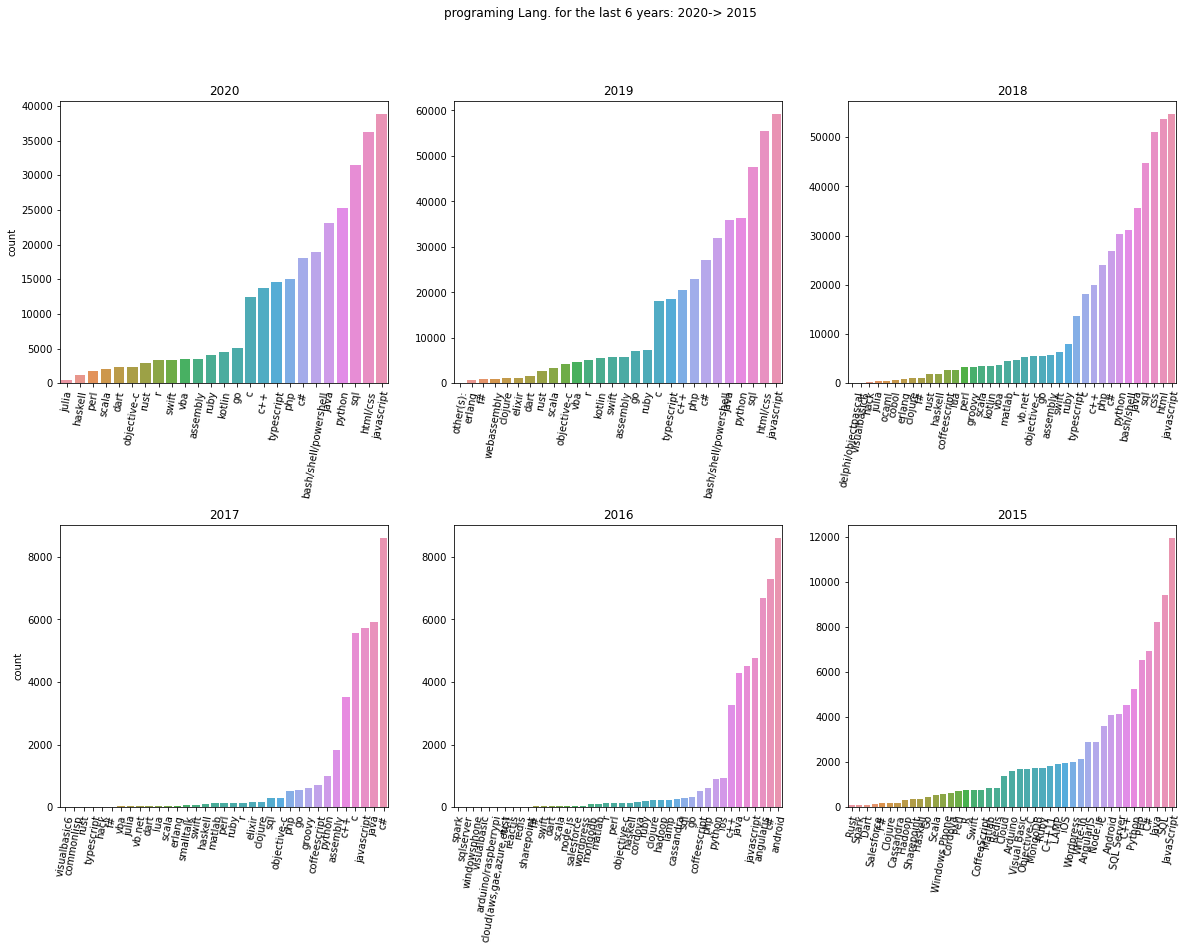

In [14]:
Visualize()

Over the last six years, from 2015 to 2020, it is obvious that Javascript programming language is most used language among respondents on StackOverflow.
However, from 2018 to 2020, the trend is clearly for the 3 progrraming languages that are most frequent: html, sql, Javascript. 

***

#### Question: What was the Job satisfaction categories' proportions over the years? 

Due to differences in column names, and column count from a dataframe to another (year to another) and differences in Job statisfaction labels (count, names): It is not feasible to generalize this process with a function (like previous one) that can undergo the process of reading, re-naming, removing NaN rows with a specific threshold, relabeling categories, ect.
To anwer this question, a barplot and a final plotline of proportions of satisfied employee full-time will be visualized, after treating each dataset at a time. the Dataset from 2015 is problematic due to large number of NaN in each row (even when filtered for full-time employees)... 

***

Survey dataset from 2020

In [4]:
#reading the data
df2020 = pd.read_csv('survey_results2020.csv')

In [5]:
# filtering the data according to full-time employee stricly & dropping the respondent number colum

df2020_employed = df2020[df2020.Employment == 'Employed full-time']
df2020_employed.drop(['Respondent'], inplace=True, axis=1)

In [6]:
# Find sum of NaN values in each row, and store them in a list

row_sum_Na = df2020_employed.isnull().sum(axis=1).tolist()

In [7]:
# find indices where sum of Na in each row is 15 or above (computed according to col nbr), 
# which mean 25% of the row has Null values

indices = [index for index, element in enumerate(row_sum_Na) if element >= 15]

In [8]:
# Drop the rows from the DataFrame where the row has 25% and more of NaN values

df2020_employed.drop(df2020_employed.index[indices], inplace=True)

In [9]:
# unique Job satisfaction categories 
df2020_employed.JobSat.unique()

array(['Slightly dissatisfied', 'Very satisfied', 'Very dissatisfied',
       'Slightly satisfied', 'Neither satisfied nor dissatisfied', nan],
      dtype=object)

In [10]:
#Before re labelling and reducing the Job Satisfaction to 3 levels : dissatisfied, Neutral, Satisfied
# rows in the dataframe that have NaN values in JobSat colum, will be removed

df2020_employed.drop(df2020_employed[df2020_employed['JobSat'].isnull()].index, inplace = True)

In [11]:
# create the new JobSatisfaction column with 3 labels only -relabeling. 

conditions =[(df2020_employed.JobSat == 'Slightly dissatisfied') | (df2020_employed.JobSat == 'Very dissatisfied'),
            (df2020_employed.JobSat == 'Slightly satisfied') | (df2020_employed.JobSat == 'Very satisfied'),
            (df2020_employed.JobSat == 'Neither satisfied nor dissatisfied')]

values = ['dissatisfied', 'satisfied', 'neutral']

df2020_employed['JobSatisfaction'] = np.select(conditions, values)

In [12]:
df2020_employed['JobSatisfaction'].unique()

array(['dissatisfied', 'satisfied', 'neutral'], dtype=object)

In [13]:
# Drop the old JobSat column

df2020_employed.drop(['JobSat'], inplace=True, axis=1)

In [14]:
# create a small dataframe of Job Satisfaction counts for the year 2020
df2020_empl_JobSat = pd.DataFrame(df2020_employed.JobSatisfaction.value_counts().reset_index())

In [15]:
df2020_empl_JobSat.columns =['JobSatisfaction', 'count']

In [16]:
df2020_empl_JobSat

,JobSatisfaction,count
0,satisfied,22366
1,dissatisfied,8562
2,neutral,4252


***

Survey dataset from 2019

In [17]:
df2019 = pd.read_csv('survey_results2019.csv')

In [18]:
df2019_employed = df2019[df2019.Employment == 'Employed full-time'] #select only emplyed full time 
df2019_employed.drop(['Respondent'], inplace=True, axis=1) # drop respondent colum

In [19]:
# Find sum of NaN values in each row, and store them in a list 

row_sum_Na = df2019_employed.isnull().sum(axis=1).tolist()

In [20]:
# find indices where sum of Na in each row is 21 or above (computed according to col nbr), 
# which mean 25% of the row has Null values

indices = [index for index, element in enumerate(row_sum_Na) if element >= 21]

In [21]:
# Drop the rows from the DataFrame where the row has 25% and more NaN values

df2019_employed.drop(df2019_employed.index[indices], inplace=True)

In [22]:
df2019_employed.JobSat.unique()

array(['Slightly satisfied', 'Slightly dissatisfied', 'Very satisfied',
       'Neither satisfied nor dissatisfied', 'Very dissatisfied', nan],
      dtype=object)

In [23]:
#Before re labelling and reducing the Job Satisfaction to 3 levels : dissatisfied, Neutral, Satisfied
# rows in the dataframe that have NaN values in JobSat colum, will be removed

df2019_employed.drop(df2019_employed[df2019_employed['JobSat'].isnull()].index, inplace = True)

In [24]:
# create the new JobSatisfaction column with 3 labels only -relabeling  

conditions =[(df2019_employed.JobSat == 'Slightly dissatisfied') | (df2019_employed.JobSat == 'Very dissatisfied'),
            (df2019_employed.JobSat == 'Slightly satisfied') | (df2019_employed.JobSat == 'Very satisfied'),
            (df2019_employed.JobSat == 'Neither satisfied nor dissatisfied')]

values = ['dissatisfied', 'satisfied', 'neutral']

df2019_employed['JobSatisfaction'] = np.select(conditions, values)

In [25]:
df2019_employed['JobSatisfaction'].unique()

array(['satisfied', 'dissatisfied', 'neutral'], dtype=object)

In [26]:
# Drop the old JobSat column
df2019_employed.drop(['JobSat'], inplace=True, axis=1)

In [27]:
# create a small dataframe of Job Satisfaction counts for the year 2019
df2019_empl_JobSat = pd.DataFrame(df2019_employed.JobSatisfaction.value_counts().reset_index())
df2019_empl_JobSat.columns =['JobSatisfaction', 'count'] # rename columns 
df2019_empl_JobSat

,JobSatisfaction,count
0,satisfied,39700
1,dissatisfied,13380
2,neutral,7035


***

Survey Dataset from 2018

In [28]:
df2018 = pd.read_csv('survey_results2018.csv')

In [29]:
df2018_employed = df2018[df2018.Employment == 'Employed full-time'] #select only employed full time 
df2018_employed.drop(['Respondent'], inplace=True, axis=1) # drop respondent colum

In [30]:
# Find sum of NaN values in each row, and store them in a list 

row_sum_Na = df2018_employed.isnull().sum(axis=1).tolist()

In [31]:
# find indices where sum of Na in each row is 32 or above (computed according to col. nbr), 
#which mean 25% of the row has Null values 

indices = [index for index, element in enumerate(row_sum_Na) if element >= 32]

In [32]:
# Drop the rows from the DataFrame where the row has 25% and more NaN values

df2018_employed.drop(df2018_employed.index[indices], inplace=True)

In [33]:
df2018_employed.JobSatisfaction.unique()

array(['Moderately dissatisfied', 'Slightly satisfied',
       'Moderately satisfied', 'Neither satisfied nor dissatisfied',
       'Extremely satisfied', 'Slightly dissatisfied',
       'Extremely dissatisfied', nan], dtype=object)

In [34]:
#Before re labelling and reducing the Job Satisfaction to 3 levels : dissatisfied, Neutral, Satisfied
# rows in the dataframe that have NaN values in JobSat colum, will be removed

df2018_employed.drop(df2018_employed[df2018_employed['JobSatisfaction'].isnull()].index, inplace = True)

In [35]:
# create the new JobSatisfaction column with 3 labels only -relabeling 

conditions =[(df2018_employed.JobSatisfaction == 'Slightly dissatisfied') |
             (df2018_employed.JobSatisfaction == 'Moderately dissatisfied') | 
             (df2018_employed.JobSatisfaction == 'Extremely dissatisfied'),
            (df2018_employed.JobSatisfaction == 'Slightly satisfied') | 
             (df2018_employed.JobSatisfaction == 'Moderately satisfied') |
             (df2018_employed.JobSatisfaction == 'Extremely satisfied'),
            (df2018_employed.JobSatisfaction == 'Neither satisfied nor dissatisfied')]

values = ['dissatisfied', 'satisfied', 'neutral']

df2018_employed['Job_Satisfaction'] = np.select(conditions, values)

In [36]:
df2018_employed['Job_Satisfaction'].unique()

array(['dissatisfied', 'satisfied', 'neutral'], dtype=object)

In [37]:
# Drop the old JobSat column
df2018_employed.drop(['JobSatisfaction'], inplace=True, axis=1)

In [38]:
# create a small dataframe of Job Satisfaction counts for the year 2019
df2018_empl_JobSat = pd.DataFrame(df2018_employed.Job_Satisfaction.value_counts().reset_index())
df2018_empl_JobSat.columns =['JobSatisfaction', 'count'] # rename columns 
df2018_empl_JobSat

,JobSatisfaction,count
0,satisfied,31292
1,dissatisfied,10519
2,neutral,2694


***

Survey Dataset from year 2017 

In [39]:
df2017 = pd.read_csv('survey_results2017.csv')

In [40]:
df2017_employed = df2017[df2017.EmploymentStatus == 'Employed full-time'] #select only emplyed full time 
df2017_employed.drop(['Respondent'], inplace=True, axis=1) # drop respondent colum

In [41]:
# Find sum of NaN values in each row, and store them in a list 

row_sum_Na = df2017_employed.isnull().sum(axis=1).tolist()

In [42]:
# find indices where sum of Na in each row is 38 or above (computed according to col. nbr), 
#which means 25% of the row has Null values 

indices = [index for index, element in enumerate(row_sum_Na) if element >= 38]

In [43]:
# Drop the rows from the DataFrame where the row has 25% and more NaN values

df2017_employed.drop(df2017_employed.index[indices], inplace=True)

In [44]:
df2017_employed.JobSatisfaction.unique()

array([ 7.,  6.,  8.,  4.,  5.,  9.,  3., 10.,  2.,  1.,  0., nan])

job statisfaction in the 2017 survey is numercial on a scale from 0 to 10. (considering 10 very much satisfied-and above 5 and 5 neutral and below 5 dissatisfied)

In [45]:
#Before re labelling and reducing the Job Satisfaction to 3 levels : dissatisfied, Neutral, Satisfied
# rows in the dataframe that have NaN values in JobSat colum, will be removed

df2017_employed.drop(df2017_employed[df2017_employed['JobSatisfaction'].isnull()].index, inplace = True)

In [46]:
# create the new JobSatisfaction column with 3 labels only -relabeling

conditions =[(df2017_employed.JobSatisfaction < 5),
             (df2017_employed.JobSatisfaction > 5),
            (df2017_employed.JobSatisfaction ==  5)]

values = ['dissatisfied', 'satisfied', 'neutral']

df2017_employed['Job_Satisfaction'] = np.select(conditions, values)

In [47]:
df2017_employed['Job_Satisfaction'].unique()

array(['satisfied', 'dissatisfied', 'neutral'], dtype=object)

In [48]:
# Drop the old JobSat column
df2017_employed.drop(['JobSatisfaction'], inplace=True, axis=1)

In [49]:
# create a dataframe of job satisfaction count for the year 2017 
df2017_empl_JobSat = pd.DataFrame(df2017_employed.Job_Satisfaction.value_counts().reset_index())
df2017_empl_JobSat.columns =['JobSatisfaction', 'count']
df2017_empl_JobSat

,JobSatisfaction,count
0,satisfied,5432
1,dissatisfied,1140
2,neutral,760


***

Survey dataset from the year 2016

In [50]:
df2016 = pd.read_csv('survey_results2016.csv')

In [51]:
df2016_employed = df2016[df2016.employment_status == 'Employed full-time'] #select only emplyed full time 
df2016_employed.drop(['Unnamed: 0'], inplace=True, axis=1) # drop respondent colum

In [52]:
# Find sum of NaN values in each row, and store them in a list 

row_sum_Na = df2016_employed.isnull().sum(axis=1).tolist()

In [53]:
# find indices where sum of Na in each row is 16 or above(computed from the col. nbr), 
#which means 25% of the row has Null values 

indices = [index for index, element in enumerate(row_sum_Na) if element >= 16]

In [54]:
# Drop the rows from the DataFrame where the row has 25% and more NaN values

df2016_employed.drop(df2016_employed.index[indices], inplace=True)

In [55]:
df2016_employed.job_satisfaction.unique()

array(['I love my job', "I'm somewhat satisfied with my job",
       "I'm somewhat dissatisfied with my job",
       "I'm neither satisfied nor dissatisfied", 'Other (please specify)',
       'I hate my job', "I don't have a job", nan], dtype=object)

In [56]:
#Before re labelling and reducing the Job Satisfaction to 3 levels : dissatisfied, Neutral, Satisfied
# rows in the dataframe that have NaN values in JobSat colum, will be removed, 
# wrong label : I do not have a job. should not be here, 'other' should be be here -. all wrong labled rows are droped

df2016_employed.drop(df2016_employed[df2016_employed['job_satisfaction'].isnull()].index, inplace = True)
df2016_employed.drop(df2016_employed[df2016_employed['job_satisfaction']== "I don't have a job"].index, inplace = True)
df2016_employed.drop(df2016_employed[df2016_employed['job_satisfaction']== "Other (please specify)"].index, inplace = True)

In [57]:
df2016_employed.job_satisfaction.unique()

array(['I love my job', "I'm somewhat satisfied with my job",
       "I'm somewhat dissatisfied with my job",
       "I'm neither satisfied nor dissatisfied", 'I hate my job'],
      dtype=object)

In [58]:
# create the new JobSatisfaction column with 3 labels only -recategorization 

conditions =[(df2016_employed.job_satisfaction == 'I hate my job') |
             (df2016_employed.job_satisfaction == "I'm somewhat dissatisfied with my job"),
             (df2016_employed.job_satisfaction == 'I love my job') |
             (df2016_employed.job_satisfaction == "I'm somewhat satisfied with my job"),
            (df2016_employed.job_satisfaction ==  "I'm neither satisfied nor dissatisfied")]

values = ['dissatisfied', 'satisfied', 'neutral']

df2016_employed['JobSatisfaction'] = np.select(conditions, values)

In [59]:
df2016_employed['JobSatisfaction'].unique()

array(['satisfied', 'dissatisfied', 'neutral'], dtype=object)

In [60]:
# Drop the old JobSat column
df2016_employed.drop(['job_satisfaction'], inplace=True, axis=1)

In [61]:
# create a small dataframe of the job satisfaction count for 2016
df2016_empl_JobSat = pd.DataFrame(df2016_employed.JobSatisfaction.value_counts().reset_index())
df2016_empl_JobSat.columns =['JobSatisfaction', 'count']
df2016_empl_JobSat

,JobSatisfaction,count
0,satisfied,21742
1,dissatisfied,4200
2,neutral,3226


***

In [62]:
# storing the dataframes of Job satisfaction categories count in a dictionary 

keys=['df{}_empl_JobSat'.format(i) for i in range(2016, 2021)]

df_empl_JobSat={'df2016_empl_JobSat': df2016_empl_JobSat,
                  'df2017_empl_JobSat': df2017_empl_JobSat,
                  'df2018_empl_JobSat': df2018_empl_JobSat,
                  'df2019_empl_JobSat': df2019_empl_JobSat,
                  'df2020_empl_JobSat': df2020_empl_JobSat}

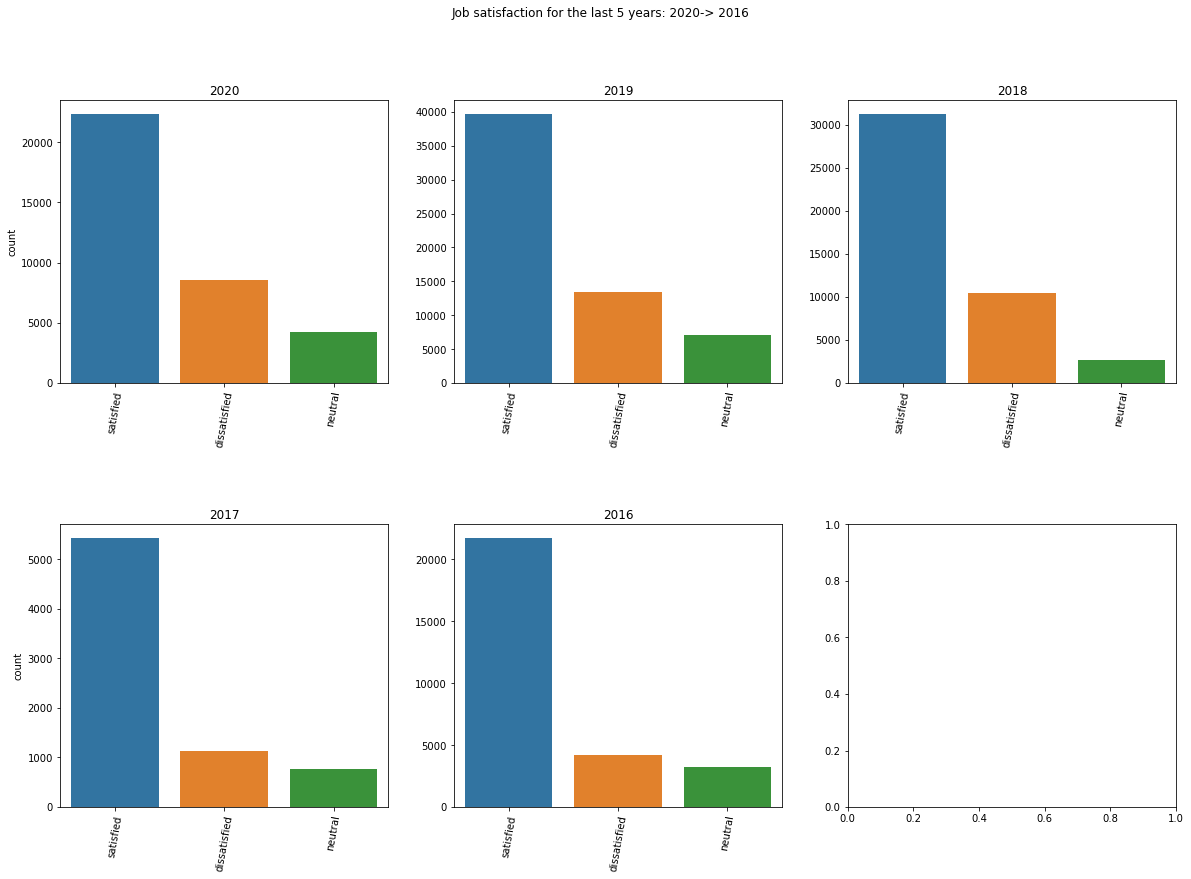

In [63]:
        #visualization of barplots accorss the 5 years, Job satisfaction categories count 
        
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

fig.suptitle('Job satisfaction for the last 5 years: 2020-> 2016')
plt.subplots_adjust(hspace=0.5)

g1 = sns.barplot(ax=axes[0, 0], data=df_empl_JobSat['df2020_empl_JobSat'], x='JobSatisfaction', y='count')
g1.set_xticklabels(g1.get_xticklabels(), rotation=80)
g1.set_title('2020')
g1.set_xlabel('')
        
g2 = sns.barplot(ax=axes[0, 1], data=df_empl_JobSat['df2019_empl_JobSat'], x='JobSatisfaction', y='count')
g2.set_xticklabels(g2.get_xticklabels(), rotation=80)
g2.set_title('2019')
g2.set_xlabel('')
g2.set_ylabel('')
        
g3 = sns.barplot(ax=axes[0, 2], data=df_empl_JobSat['df2018_empl_JobSat'], x='JobSatisfaction', y='count')
g3.set_xticklabels(g3.get_xticklabels(), rotation=80)
g3.set_title('2018')
g3.set_xlabel('')
g3.set_ylabel('')
        
g4 = sns.barplot(ax=axes[1, 0], data=df_empl_JobSat['df2017_empl_JobSat'], x='JobSatisfaction', y='count')
g4.set_xticklabels(g4.get_xticklabels(), rotation=80)
g4.set_title('2017')
g4.set_xlabel('')
        
g5 = sns.barplot(ax=axes[1, 1], data=df_empl_JobSat['df2016_empl_JobSat'], x='JobSatisfaction', y='count')
g5.set_xticklabels(g5.get_xticklabels(), rotation=80)
g5.set_title('2016')
g5.set_xlabel('')
g5.set_ylabel('');

The barplot of Job satisfactions over the last 5 years show a consistency of high Job satisfaction compared to Neutral respondents and dissatisfied ones. However, the sample sizes are not consistent from a year to another, which makes the comparison biased. 
Another visualization can solve this issue and ascertain the comparison from one year to the next, by drawing lineplots of proportions/percentages of each Job satisfaction category in a year. 

***

In [64]:
# compute precentages in df_empl_JobSat dataframes
y = 2016
for k in keys:
    #create a new column of percentages for each dataframe and apply a function that compute %
    df_empl_JobSat[k]['Percentages']=df_empl_JobSat[k][['count']].apply(lambda x: 100* x/ float(x.sum())).round(2)
    # add a year colum before concatenating the dataframes of each year together
    df_empl_JobSat[k]['year'] = y 
    # increase the year before looping again
    y = y+ 1

In [65]:
# concatenate all dataframes together
my_dfs = [df_empl_JobSat[k] for k in keys]
df_employment_Satisfaction = pd.concat(my_dfs)
df_employment_Satisfaction

,JobSatisfaction,count,Percentages,year
0,satisfied,21742,74.54,2016
1,dissatisfied,4200,14.40,2016
2,neutral,3226,11.06,2016
0,satisfied,5432,74.09,2017
1,dissatisfied,1140,15.55,2017
2,neutral,760,10.37,2017
0,satisfied,31292,70.31,2018
1,dissatisfied,10519,23.64,2018
2,neutral,2694,6.05,2018
0,satisfied,39700,66.04,2019


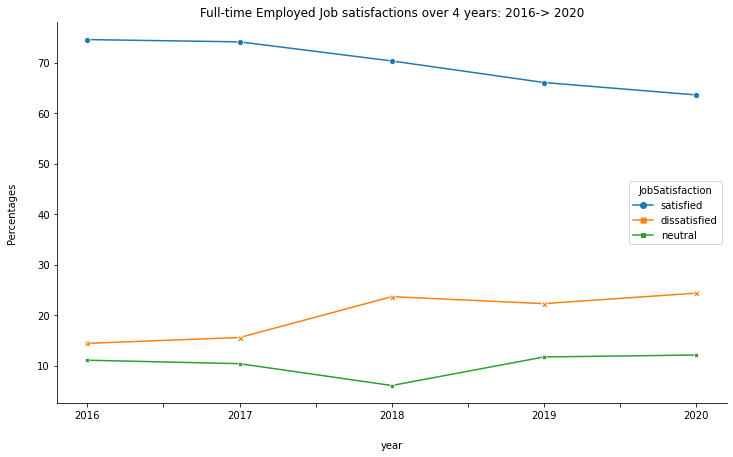

In [66]:
# visualize lineplots of job satisfactions percentages over the years: 2016 -> 2020
plt.figure(figsize=(12,7))
plt.title('Full-time Employed Job satisfactions over 4 years: 2016-> 2020')
ax = sns.lineplot(data=df_employment_Satisfaction, x="year", y="Percentages", hue="JobSatisfaction",dashes=False,
             markers=True, style='JobSatisfaction')
sns.despine(ax=ax , top=True, right=True, left=False, bottom=False)
ax.set_xticklabels(['','2016','','2017','','2018','','2019','','2020'])
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20;

Over the years, from 2016 to 2021, the job satisfaction for Full-time employee has declined from ~75% to ~65%. 
Nevertheless, the symmetry between the 2 lineploints (i.e. Neutral & dissatisfied) is clearly obvious. From 2016 to 2017 the downward trend in Neutral is reciprocated with an unpward trend with the Dissatisfied. This reciprocal nature between Neutral respondents and Dissatisfied is more exposed between 2017 and 2019.
For the sake of investigating the significance of the downward trend with satisfied respondent, a Chi-square goodness of fit can be conducted with the various proportion over the 4 years for this category.

Ho: the statisfied proportion of respondent is the same over the years from 2016 to 2020, the decrease is not significant.

H1: there is a significance in the decrease of Satisfied proportion of respondent.

In [67]:
#observed proportions of Satisfied over the years: we chose proportions not counts, since the sample size differ
# from year to year. proportion is more adequate and standardized. 

observed =[74.54, 74.09, 70.31, 66.04, 63.58]

In [68]:
(74.54+74.09+70.31+66.04+63.58)/5 # expected considering all proportions are the same. 

69.712

In [69]:
expected = [69.71, 69.712, 69.712, 69.712, 69.712]

In [70]:
#perform Chi-Square Goodness of Fit Test

stats.chisquare(f_obs=observed, f_exp=expected)

Power_divergenceResult(statistic=1.3475307739394617, pvalue=0.8532611907182079)

p value is not less than 0.05 (5%), we fail to reject the Null hypothesis that claims: all satisfaction proportions over the years are the same and the decrease is not significant.